In [59]:
from crewai import Agent, Task, Crew, Process, LLM
from langchain_openai import ChatOpenAI
import os 
import sys 
from pprint import pprint
from IPython.display import display, Markdown, Latex

sys.path.append('../')

from utils.pdf import read_pdf
from pydantic import BaseModel, Field
from typing import List

Seems like crewAI leverages Litellm for model inference. LM Studio isn't one of the listed providers. Seems like custom models off HF may be a challenge to use. Lets leverage Ollama models

In [26]:
model = "ollama/llama3.2"
base_url = "http://localhost:11434"

In [58]:
llm = LLM(base_url=base_url, model=model, temperature=0, api_key="test")
pdf_text = read_pdf("../data/Sohn_Visual_Prompt_Tuning_for_Generative_Transfer_Learning_CVPR_2023_paper.pdf")

In [62]:
class Summary(BaseModel):
    summary: str=Field(..., description="Cohesive summary of the text.")
    key_points: List[str] = Field(..., description="Key points, figures, facts from the input text.")
    source: str = Field(..., description="Source of the summary. It can be a URL, a name, or a description.")

In [64]:
summarizer_agent = Agent(
    role="summarizer",
    goal="Generating a cohesive summary of the given text and extracting key points from it.",
    backstory="""You are working on a project that will summarize given text""",
    llm=llm,
    verbose=True,
    memory=False
)

In [66]:
sumamry_task = Task(
    agent=summarizer_agent,
    output_json = Summary,
    description="Conduct a thorough summarization of the given text. \n {text} \n Include key points, figures, and facts from the text.",
    expected_output = "A cohesive summary of the given text and extracting key points from it.",
)

In [67]:
crew = Crew(
    tasks=[sumamry_task],
    agents=[summarizer_agent],
    verbose=True,
  
)

2024-10-19 17:04:18,426 - 133946742433600 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


In [70]:
crew_output = crew.kickoff(inputs={"text": pdf_text})

# Agent: summarizer
## Task: Conduct a thorough summarization of the given text. 
 # Visual Prompt Tuning for Generative Transfer Learning


Kihyuk Sohn, Huiwen Chang, Jos´e Lezama, Luisa Polania,

Han Zhang, Yuan Hao, Irfan Essa, Lu Jiang

Google Research

Figure 1. Image synthesis by knowledge transfer. Unlike previous works using GANs as base model and test transfer on relatively narrow
visual domains, we transfer knowledge of generative vision transformers [7, 15] to a wide range of visual domains, including natural
(e.g., scene, flower), specialized (e.g., satellite, medical), and structured (e.g., road scenes, infograph, sketch) with a few training images.
Notably, the prompt tuning significantly improves the prior best FID on two benchmarks ImageNet (85.9!16.3) and Places (71.3!24.2).


**Abstract**

_Learning generative image models from various domains_

_efficiently needs transferring knowledge from an image syn-_
_thesis model trained on a large dataset. We present a recipe_

/home/owen/anaconda3/envs/gen-ai/lib/python3.12/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


 Failed to convert text into JSON, error: 1 validation error for Summary
key_points
  Input should be a valid array [type=list_type, input_value='["Prompt tuning for pre-... on transfer learning"]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.8/v/list_type. Using raw output instead.


### Small Language Models suck at summarizing entire text at once even though it fits into context window


* Probably need to chunk the document and build summaries
https://python.langchain.com/docs/tutorials/summarization/#map-reduce 

In [99]:
from langchain_ollama.llms import OllamaLLM


In [112]:
lc_llm = OllamaLLM(model="llama3.2")


In [113]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

map_chain = map_prompt | lc_llm | StrOutputParser()

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

reduce_chain = reduce_prompt | lc_llm | StrOutputParser()

In [114]:
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.documents import Document

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=100
)
split_docs = text_splitter.split_documents([Document(page_content=pdf_text)])
print(f"Generated {len(split_docs)} documents.")

Generated 9 documents.


In [118]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


import tiktoken
def num_tokens_from_string(string: str, encoding_name="cl100k_base" ) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(num_tokens_from_string(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()




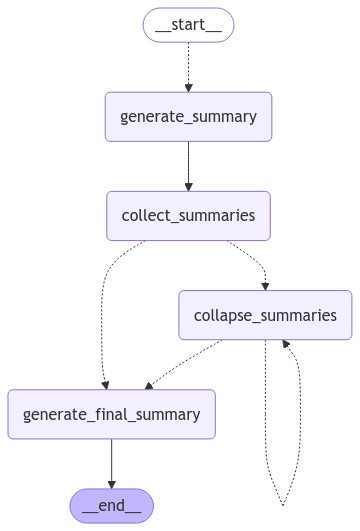

In [119]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [120]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['generate_final_summary']


In [122]:
step.keys()

dict_keys(['generate_final_summary'])

In [126]:

print(step.get('generate_final_summary').get('final_summary'))

Here is a consolidated summary of the main themes:

**Advances in Generative Models for Image Synthesis**

* Research papers focus on advancing Generative Adversarial Networks (GANs) and other generative models for image synthesis using autoregressive vision transformers, diffusion models, transformers, and self-supervised learning.
* New approaches include visual prompt tuning, which involves prepending learnable tokens to guide the model to generate images in the target distribution.

**Importance of Prompt Tuning and Transfer Learning**

* The importance of prompt tuning is highlighted, with various techniques and approaches reviewed, including diffusion models, transformers, and self-supervised learning.
* Prompt learning can improve performance on image synthesis tasks, while diffusion models have surpassed GANs in image synthesis quality.
* Transfer learning and fine-tuning are crucial for adapting models to new tasks and domains.

**Methods for Efficient Image Synthesis**

* The

This shows it's better for small language models to see less data to generate better responses than to stuff everything into it. LangGraph can be integrated with CrewAI as well. Or can leverage crewAI Flows

Other option is providing tools to crewAI and having a 'manager' decide what tools to call. May be tricky with small language models. Need to do feedback well
* Manager = hierarchical Process = More like planner and executor type
* output of one task is automatically passed to the next task
* Kickoff Crew for Each -> May be more similar to creating tasks for each component within a piece of text: https://docs.crewai.com/how-to/kickoff-for-each
* Langtrace for monitoring - OS https://app.langtrace.ai/onboarding